In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp

from matplotlib import pyplot as plt
from helpers import (
    draw_edges, get_borderless_fig, pos_spring_layout, signed_layout, get_lcc, signed_normalized_laplacian, flatten,
    pos_adj, neg_adj
)
from viz_helpers import draw_query_result

In [101]:
def avg_pos_deg(nodes):
    return pos_A[nodes, :][:, nodes].sum() / nodes.shape[0]

def avg_neg_deg(nodes):
    return neg_A[nodes, :][:, nodes].sum() / nodes.shape[0]

def cohe(C1, C2):
    n1, n2 = C1.shape[0], C2.shape[0]
    cohe1 = pos_A[C1, :][:, C1].sum() / (n1 * (n1-1))
    cohe2 = pos_A[C2, :][:, C2].sum() / (n2 * (n2-1))
    return np.mean([cohe1, cohe2])

def oppo(C1, C2):
    return neg_A[C1, :][:, C2].sum() / C1.shape[0] / C2.shape[0]

def agreement(C1, C2):
    n_bad_pos = pos_A[C1, :][:, C2].sum() * 2
    n_bad_neg = neg_A[C1, :][:, C1].sum() + neg_A[C2, :][:, C2].sum()
    C = list(C1) + list(C2)
    n_total = pos_A[C, :][:, C].sum() + neg_A[C, :][:, C].sum()
    return 1 - (n_bad_pos + n_bad_neg) / n_total

def get_row_by_query(query):
    return df[df['query'] == query].iloc[0]

def show(q, **kwargs):
    r = get_row_by_query(q)
    fig, ax = draw_query_result(g, r['C1'], r['C2'], show_query=True, r=r, **kwargs)
    ax.set_title('q:{}, agr:{:.2f}, ham:{:.2f}, opp:{:.2f}, coh:{:.2f}'.format(q, r['agreement'], r['ham'], r['opp'], r['coh']))

In [151]:
graph = 'word'
g = nx.read_gpickle('graphs/{}.pkl'.format(graph))
A = nx.adj_matrix(g, weight='sign')
df = pd.read_pickle('outputs/{}.pkl'.format(graph))

In [152]:
pos_A, neg_A = pos_adj(A), neg_adj(A)

# for weighted matrix, make it unweighted
if not (pos_A.data == 1).all():
    pos_A.data = np.ones(pos_A.data.shape, dtype='float64')
if not (neg_A.data == 1).all():
    neg_A.data = np.ones(neg_A.data.shape, dtype='float64')

In [153]:
df['size1'] = df['C1'].apply(lambda d: d.shape[0])
df['size2'] = df['C2'].apply(lambda d: d.shape[0])
df['balancedness'] = np.minimum(df['size1'], df['size2']) / (df['size1'] + df['size2'])

## filtering

exclude those that:

- C1 or C2 is small (<10 nodes)
- k != 200

In [154]:
df = df[df['k'] == 200]
df = df[(df['size1'] > 10) & (df['size2'] > 10)]

## data fields to add

- query degree
- avg pos/neg degree inside C1|C2
- opposition between C1 and C2

In [155]:
df['qdeg'] = df['query'].apply(lambda n: g.degree(n))

In [156]:
df['posdeg1'] = df['C1'].apply(avg_pos_deg)
df['posdeg2'] = df['C2'].apply(avg_pos_deg)
df['negdeg1'] = df['C1'].apply(avg_neg_deg)
df['negdeg2'] = df['C2'].apply(avg_neg_deg)

In [157]:
df['coh'] = df[['C1', 'C2']].apply(lambda d: cohe(d['C1'], d['C2']), axis=1)
df['opp'] = df[['C1', 'C2']].apply(lambda d: oppo(d['C1'], d['C2']), axis=1)
df['ham'] = 2 * df['coh'] * df['opp'] / (df['coh'] + df['opp'])

In [158]:
df['agreement'] = df[['C1', 'C2']].apply(lambda d: agreement(d['C1'], d['C2']), axis=1)

In [159]:
assert (df['coh'] >= 0).all()
assert (df['coh'] <= 1).all()
assert (df['opp'] >= 0).all()
assert (df['opp'] <= 1).all()
assert (df['ham'] >= 0).all()
assert (df['ham'] <= 1).all()
assert (df['agreement'] >= 0).all()
assert (df['agreement'] <= 1).all()


In [160]:
df[['size1', 'size2', 'posdeg1', 'posdeg2', 'negdeg1', 'negdeg2', 'opp', 'agreement']].head(3)

,size1,size2,posdeg1,posdeg2,negdeg1,negdeg2,opp,agreement
1,97,102,6.247423,3.627451,0.103093,0.0,0.026784,0.965385
4,73,84,3.260274,2.928571,0.000000,0.0,0.019080,0.994460
7,73,126,7.863014,6.412698,0.000000,0.0,0.024571,1.000000


In [161]:
fields_to_show = ['query', 'best_beta', 'size1', 'size2', 'agreement', 'ham', 'coh', 'opp']

## top-k by HAM

In [162]:
df[fields_to_show].sort_values(by='ham', ascending=False).head(3)

,query,best_beta,size1,size2,agreement,ham,coh,opp
2425,4690,0.468593,12,12,1.0,0.578891,0.651515,0.520833
919,4856,0.478703,22,13,1.0,0.426947,0.491092,0.377622
826,2457,0.357612,11,14,1.0,0.305569,0.401199,0.246753


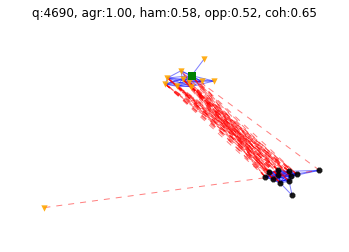

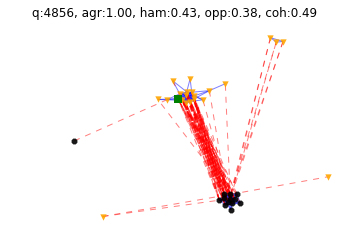

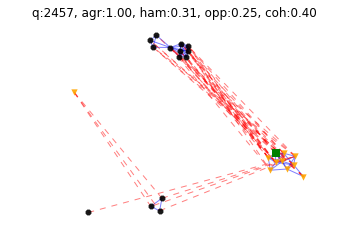

In [163]:
queries = df.sort_values(by='ham', ascending=False).head(3)['query'].tolist()
for q in queries:
    show(q)

In [170]:
if graph == 'word':
    queries = df.sort_values(by='ham', ascending=False).head(3)['query'].tolist()
    for q in queries:
        r = get_row_by_query(q)
        print('q:', q)
        print('C1:', ', '.join([g.graph['i2w'][n] for n in r['C1']]))
        print('C2:', ', '.join([g.graph['i2w'][n] for n in r['C2']]))        
        print()

q: 4690
C1: tiny, peewee, mini, infinitesimal, minuscule, miniature, minimum, diminutive, wee, baby, minute, relative
C2: infinite, bigger, larger, mammoth, giant, huge, macro, wide, bumper, large, super, broad

q: 4856
C1: larger, bigger, more, mammoth, giant, huge, macro, bumper, wide, limitless, large, super, infinite, blaring, broad, vocal, monster, better, roomy, husky, lots, shattering
C2: infinitesimal, minuscule, miniature, diminutive, tiny, wee, peewee, minute, mini, small, little, baby, worse

q: 2457
C1: nightfall, sundown, dusk, sunset, twilight, evening, nighttime, night, murkiness, darkness, rosiness
C2: sunup, daybreak, morning, dawning, daylight, sunrise, afternoon, daytime, dawn, day, pallor, paleness, illumination, whiteness



## top-k by agreement

In [164]:
df[fields_to_show].sort_values(by='agreement', ascending=False).head(3)

,query,best_beta,size1,size2,agreement,ham,coh,opp
1468,1391,0.542933,50,40,1.0,0.041083,0.049725,0.035000
826,2457,0.357612,11,14,1.0,0.305569,0.401199,0.246753
854,1975,0.455702,44,38,1.0,0.059642,0.094080,0.043660


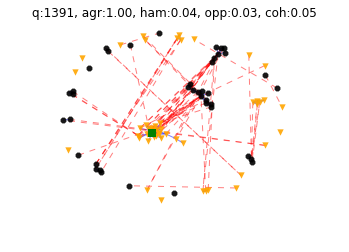

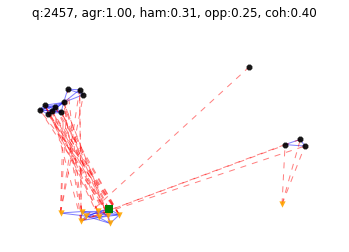

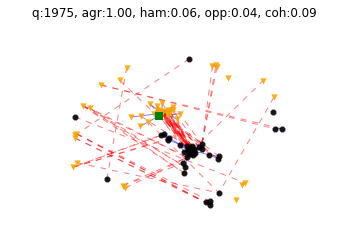

In [165]:
queries = df.sort_values(by='agreement', ascending=False).head(3)['query'].tolist()
for q in queries:
    show(q, use_lcc=False)

## top-k by opposition

In [166]:
df[fields_to_show].sort_values(by='opp', ascending=False).head(3)

,query,best_beta,size1,size2,agreement,ham,coh,opp
2425,4690,0.468593,12,12,1.0,0.578891,0.651515,0.520833
919,4856,0.478703,22,13,1.0,0.426947,0.491092,0.377622
2481,510,0.506576,12,13,1.0,0.297767,0.288462,0.307692


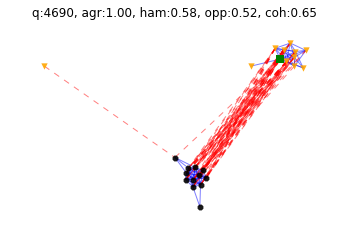

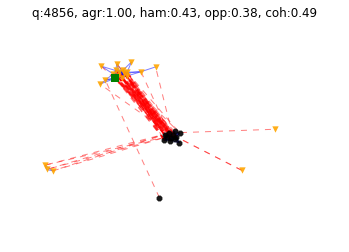

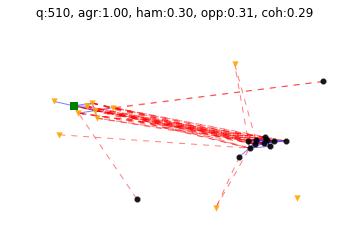

In [167]:
queries = df.sort_values(by='opp', ascending=False).head(3)['query'].tolist()
for q in queries:
    show(q, use_lcc=False)

## top-k by coherence

In [168]:
df[fields_to_show].sort_values(by='coh', ascending=False).head(3)

,query,best_beta,size1,size2,agreement,ham,coh,opp
2425,4690,0.468593,12,12,1.0,0.578891,0.651515,0.520833
919,4856,0.478703,22,13,1.0,0.426947,0.491092,0.377622
1414,3774,0.486982,15,11,1.0,0.253159,0.452381,0.175758


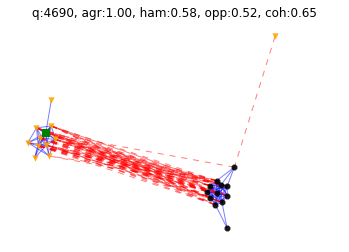

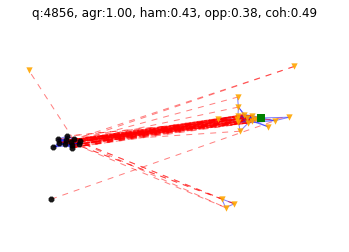

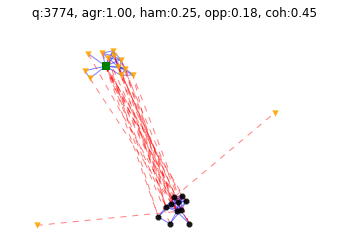

In [169]:
queries = df.sort_values(by='coh', ascending=False).head(3)['query'].tolist()
for q in queries:
    show(q)